<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
# COMPSCI 371 Homework 9

### Problem 0 (5 points)

Partners: Brian Janger, Matthew Wang, Caleb Watson

## Part 1: Impurity Measures 

### Problem 1.1

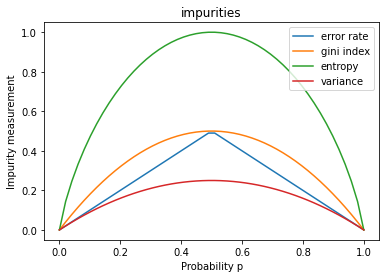

In [17]:
import numpy as np
from matplotlib import pyplot as plt

def plot_impurities(names, title):
    
    plt.figure()
    plt.xlabel('Probability p')
    plt.ylabel('Impurity measurement')
    plt.title(title)
    
    p_dist = np.linspace(0,1)
    combined = list(zip(p_dist, 1-p_dist))
    
    for name in names:
        impurity = []
        if 'error rate' in name:
            impurity = [1-max(value[0],value[1]) for value in combined]          
        if 'gini index' in name:
            impurity = [1-(np.power(value[0],2) + np.power(value[1],2)) for value in combined]
        if 'entropy' in name:
            for value in combined:
                if value[0] == 0 or value[1] == 0: impurity.append(0)
                else: impurity.append(-1*((value[0]*np.log2(value[0]))+(value[1]*np.log2(value[1]))))           
        if 'variance' in name:
            for value in combined:
                m = value[1]
                impurity_sum = 0
                for k in range(0,2):
                    impurity_sum += np.power(k-m, 2)*(value[k])
                impurity.append(impurity_sum)
        # impurity normalization fort 1.2
        if 'normalized' in name:
            max_impure = max(impurity)
            impurity = impurity/max_impure
        plt.plot(p_dist, impurity, label=name)
    
    plt.legend()
            

plot_impurities(['error rate', 'gini index', 'entropy', 'variance'], 'impurities')

### Problem 1.2

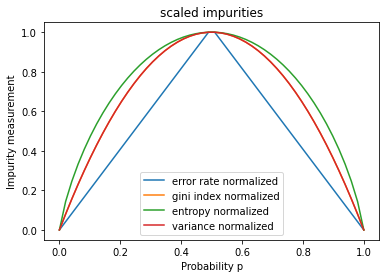

In [18]:
plot_impurities(['error rate normalized', 'gini index normalized', 
                 'entropy normalized', 'variance normalized'], 'scaled impurities')

### Problem 1.3 (Exam Style)

When normalizing the plots to their largest impurity values, we see that two of the four total methods (gini index and variance) are identical to one another when $K = 2$. 

To prove mathematically that the two plots are identical, we can expand the above expressions as follows, where $p_0 = q$ and $p_1 = p$.

Gini Index:

$i(S) = 1 - \sum_{k=0}^{K-1} p_k^2$

$= 1 - (p_1^2 + p_0^2)$

$= 1 - (p^2 - q^2)$

$= 1 - ((1 - q)^2 - q^2)$

$= 1 - (1 - 2q + q^2 + q^2)$

$= -2q^2+2q$

Variance:

$m = \sum_{k=0}^{K-1} kp_k = 1*p_1 = p$

$i(S) = \sum_{k=0}^{K-1} (k-m)^2*p_k$

$= (1 - p)^2p + (-p)^2*q$

$= (1-(1-q))^2(1-q) + (-1+q)^2*q$

$= q^2 (1-q) + (-1+q)^2*q$

$= q^2 (1-q) + (1-2q+q^2)*q$

$= -q^2 + q$

When looking at the maximum value acheived by the impurities for both methods, we see that both occur at $p = q = 0.5$, with the $i_g(S) = 0.5$ and $i_v(S) = 0.25$. Dividing the above derived expressions by these values results in the same expression of $-4q^2 + 4q$, therefore proving they are identical.


### Problem 1.4 (Exam Style)

In [5]:
import numpy as np


K = 3
Y = np.arange(K)
S = [0, 1, 1, 0, 0, 1, 0, 0, 2, 1, 1, 0, 2, 1, 0, 0]



## Part 2: Decision Tree Basics 

### Problem 2.1 (Exam Style)

$h((5,2)) = (0.2, 0.6, 0.2)$

### Problem 2.2 (Exam Style)

The probability that the value of $h((5,2))$ is wrong is $0.4$ or $40$ percent.  

### Problem 2.3 (Exam Style)

$i_r(S) = 1 - \max_{k=0,...,2}p_k = 1 - 0.6 = 0.4$
$i_g(S) = 1 - \sum_{k=0}^{2}p_k^2 = 1 - (0.1^2 + 0.3^2 + 0.6^2) = 0.54$

## Part 3: Splits 

### Problem 3.1 (Exam Style)

$$
i(S) = \frac{1}{2}
$$

$$
\begin{array}{*{7}{c}l}
j & t & |L| & i_L & |R| & i_R & \delta &\text{best} \\\hline
1 & 3 & 1 & 0   & 3 & 1/3 & 1/4 & yes \\
1 & 5 & 2 & 1/2 & 2 & 1/2 & 0 & no \\
1 & 8 & 3 & 1/3 & 1 & 0 & 1/4 & yes\\
2 & 3 & 1 & 0 & 3 & 1/3 & 1/4 & yes\\
2 & 5 & 2 & 1/2 & 2 & 1/2 & 0 & no\\
2 & 7 & 3 & 1/3 & 1 & 0 & 1/4 & yes\\
\end{array}
$$



## Part 4: Classification Trees

In [7]:
from urllib.request import urlretrieve
from os import path as osp


def retrieve(file_name, semester='fall22', course='371', homework=9):
    if osp.exists(file_name):
        print('Using previously downloaded file {}'.format(file_name))
    else:
        fmt = 'https://www2.cs.duke.edu/courses/{}/compsci{}/homework/{}/{}'
        url = fmt.format(semester, course, homework, file_name)
        urlretrieve(url, file_name)
        print('Downloaded file {}'.format(file_name))

In [8]:
import pickle

classification_file = 'classification_data.pickle'
for file_name in ('tree.py', 'draw.py', classification_file):
    retrieve(file_name)
    
with open(classification_file, 'rb') as file:
    classification_data = pickle.load(file)

Downloaded file tree.py
Downloaded file draw.py
Downloaded file classification_data.pickle


In [12]:
from draw import colormap, sample_plot
from matplotlib import pyplot as plt
%matplotlib inline


def draw_samples(samples, y_range, title=None):
    cmap = colormap(y_range)
    plt.figure(figsize=(7, 7), tight_layout=True)
    sample_plot(samples, cmap, 12)
    plt.axis('off')
    plt.axis('equal')
    if title is not None:
        plt.title(title, fontsize=16)

In [13]:
training_set = classification_data['train']
y_range = classification_data['y range']
data_type = classification_data['type']

In [15]:
import numpy as np


def categorical(samples, config):
    p = [np.count_nonzero(samples['y'] == c)
         for c in range(config['K'])]
    return np.array(p, dtype=float) / np.sum(p)


def error_rate(samples, config):
    return 1. - np.amax(categorical(samples, config))

In [16]:
training_config = {
    'min samples': 1,
    'max depth': np.inf,
    'distribution': categorical,
    'impurity': error_rate,
    'K': y_range[1] - y_range[0] + 1
}

In [17]:
from tree import train_tree


t = train_tree(training_set, 0, training_config)

In [18]:
def majority(p):
    return np.argmax(p)

In [19]:
def zero_one_loss(y, y_hat):
    return float(y != y_hat)

In [20]:
from tree import predict


def performance(t, summary, samples, loss):
    xs, ys = samples['x'], samples['y']
    ys_hat = [predict(x, t, summary) for x in xs]
    losses = [loss(y, y_hat) for y, y_hat in zip (ys, ys_hat)]
    risk = np.mean(losses)
    return risk

In [21]:
for which, samples in (
        ('training', classification_data['train']),
        ('test', classification_data['test'])
):
    risk = performance(t, majority, samples, zero_one_loss)
    print('{} {} risk {:.3f}'.format(data_type, which, risk))

classification training risk 0.000
classification test risk 0.012


### Problem 4.1

### Problem 4.2

In [24]:
from draw import Box

In [25]:
def paint_tree(tau, samples, summary, y_range, title=None):
    assert tau.j < 2, 'Can only draw two-dimensional trees'
    cmap = colormap(y_range)
    plt.figure(figsize=(8, 8), tight_layout=True)
    box = Box(samples['x'], cmap=cmap)
    plt.plot((box.left, box.right, box.right, box.left, box.left),
             (box.down, box.down, box.up, box.up, box.down), 'k',
             linewidth=0.5)
    # paint_subtree(tau, box, summary)
    sample_plot(samples, cmap, 5)
    plt.axis('off')
    plt.axis('equal')
    if title is not None:
        title += ' ({} boxes)'.format(count_leaves(tau))
        plt.title(title, fontsize=16)
    plt.show()

### Problem 4.3

## Part 5: Regression Trees 

In [31]:
regression_file = 'regression_data.pickle'
retrieve(regression_file)

with open(regression_file, 'rb') as file:
    regression_data = pickle.load(file)

Downloaded file regression_data.pickle


In [32]:
training_set = regression_data['train']
y_range = regression_data['y range']
data_type = regression_data['type']

### Problem 5.1

## Part 6: Random Decision Forests

In [39]:
spiral_file = 'spiral.pickle'
retrieve(spiral_file)
with open(spiral_file, 'rb') as file:
    spiral = pickle.load(file)

Downloaded file spiral.pickle


In [41]:
from draw import coarse_regions

### Problem 6.1

### Problem 6.2 (Exam Style)